# Import and Read Data

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import gpboost as gpb
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn import metrics, model_selection
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, auc, 
                             ConfusionMatrixDisplay, mean_squared_error)
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, GroupKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
filepaths = {
    "original_data": "../Data/original_data.csv",
    "original_no_overdose_data": "../Data/original_no_overdose_data.csv",
    "original_overdose_data": "../Data/original_overdose_data.csv"
}

# Define bins and labels outside the loop, as they remain constant
bins = [12, 21, 35, 50, float('inf')]  # The last bin captures 50 and above
labels = [1, 2, 3, 4]

for key, path in filepaths.items():
    
    data = pd.read_csv(path, dtype=object)
    data['Residence_State'] = data['Residence_State(FIPS)']
    data.drop('Residence_State(FIPS)', axis=1, inplace=True)
    
    # Process The_Decedent_Age column
    data['The_Decedent_Age'] = data['The_Decedent_Age'].astype(str).str[1:].astype(int)  # Remove leading '1' and convert to int
    data['The_Decedent_Age_Group'] = pd.cut(data['The_Decedent_Age'], bins=bins, labels=labels, right=False)
    data.drop(columns=['The_Decedent_Age'], inplace=True)  # Drop the original age column
    
    globals()[key] = data

# Split Data to train, and test


In [3]:
def data_split_and_label(data_set, label_value):
    """Splits the data into train and test sets and adds a label."""
    train, test = model_selection.train_test_split(data_set, test_size=0.3)
    train.insert(0, "y_value", label_value)
    test.insert(0, "y_value", label_value)
    return train, test

# Splitting data and adding labels
train_class_0, test_class_0 = data_split_and_label(original_no_overdose_data, 0)
train_class_1, test_class_1 = data_split_and_label(original_overdose_data, 1)

# Resampling the non-overdose data
num_of_samples = len(train_class_1)
train_class_0_resampled = [train_class_0.sample(num_of_samples) for _ in range(1)]
test_class_0_resampled = [test_class_0.sample(int(3*num_of_samples/7)) for _ in range(1)]

# Combining and shuffling
arrayoftrain = [(pd.concat([train_0, train_class_1])).sample(frac=1) for train_0 in train_class_0_resampled]
arrayoftest = [(pd.concat([test_0, test_class_1])).sample(frac=1) for test_0 in test_class_0_resampled]

# Group by Race and others

In [4]:
numofclass0 = 1
def process_data(array_of_data, columns_to_drop):
    x_data = []
    y_data = []
    
    for data in array_of_data:
        data_x = data.drop(columns=columns_to_drop).sample(n=len(data))
        data_y = data_x.pop("y_value").astype(bool)
        x_data.append(data_x)
        y_data.append(data_y)
        
    return x_data, y_data

# Define columns to drop
columns_to_drop = ["The_Decedent_Education", "Residence_Met_or_Nonmet_county", "Residence_County(FIPS)", 
                   "The_Decedent_Marital_status", "General_Place_of_death_and_decedents_status", 
                   "The_Decedent_State_or_country_of_birth", "Occurrence_County_Population_size", 
                   "Occurrence_County(FIPS)", "Occurrence_State(FIPS)", "General_Day_of_week_of_death", 
                   "General_Record_Type", "General_Resident_status", "General_Manner_of_death", 
                   "The_Decedent_Date_of_Death", "Underlying_Cause_ICD-10_code", "The_Decedent_Race_Recode_5", 
                   "The_Decedent_Hispanic_Origin/Race_Recode"]

# Process main data
arrayoftrain_x, arrayoftrain_y = process_data(arrayoftrain, columns_to_drop)
arrayoftest_x, arrayoftest_y = process_data(arrayoftest, columns_to_drop)


# # Using dictionaries to process data by group
# grouped_data_keys = ['white', 'black', 'AmericanIndian', 'asian', 'hispanic', 'male', 'female', 'Metropolitan', 'Nonmetropolitan', 'Foreignresidents']
# grouped_data = {key: [] for key in grouped_data_keys}

# grouped_columns = {
#     'white': 'The_Decedent_Race',
#     'black': 'The_Decedent_Race',
#     'AmericanIndian': 'The_Decedent_Race',
#     'asian': 'The_Decedent_Race',
#     'hispanic': 'The_Decedent_Race',
#     'male': 'The_Decedent_Sex',
#     'female': 'The_Decedent_Sex',
#     'Metropolitan': 'Residence_Met_or_Nonmet_county',
#     'Nonmetropolitan': 'Residence_Met_or_Nonmet_county',
#     'Foreignresidents': 'Residence_Met_or_Nonmet_county'
# }

# grouped_values = {
#     'white': '1',
#     'black': '2',
#     'AmericanIndian': '3',
#     'asian': '4',
#     'hispanic': '6',
#     'male': 'M',
#     'female': 'F',
#     'Metropolitan': '1',
#     'Nonmetropolitan': '2',
#     'Foreignresidents': 'Z'
# }

# for key in grouped_data_keys:
#     grouped = arrayoftest[0].groupby(grouped_columns[key])
#     grouped_data[key].append(grouped.get_group(grouped_values[key]))


# # Process grouped data
# grouped_data_x, grouped_data_y = {}, {}
# for key in grouped_data_keys:
#     x, y = process_data(grouped_data[key], columns_to_drop)
#     grouped_data_x[key] = x
#     grouped_data_y[key] = y


# FixEffect

# FixEffect for XGBOOST

In [5]:
# Define X and y
X, y = arrayoftrain_x[0], arrayoftrain_y[0]

# Convert 'object' dtype columns to categorical type
categorical_columns = ['The_Decedent_Sex', 'The_Decedent_Race', 'Residence_State']

for col in categorical_columns:
    X[col] = X[col].astype('category')

# Convert columns which are numerical but represented as 'object' to their respective types
numerical_as_object = ['General_Data_year', 'The_Decedent_Age_Group']
for col in numerical_as_object:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Define the model and parameters
params = {
    'learning_rate': [0.07],
    'max_depth': [7],
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'subsample': [0.9],
    'gamma': [0.4],
    'reg_alpha': [0.005],
    'reg_lambda': [0.3],
    'tree_method': ['gpu_hist'],
    'enable_categorical': [True]
}

model = xgb.XGBClassifier()

# Outer CV for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)  # Using StratifiedKFold for balanced splits

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner CV for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(model, param_grid=params, cv=inner_cv, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Output the best parameters for each fold
    print(f'Best parameters for fold {i + 1}: {best_params}')
    
    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    
    # Getting metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    
    # Printing metrics for each fold
    print(f"Fold {i + 1}:")
#     print(f'True Positives (TP): {tp}')
#     print(f'False Positives (FP): {fp}')
#     print(f'True Negatives (TN): {tn}')
#     print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability

Best parameters for fold 1: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 1:
Accuracy: 0.7882
AUC-ROC: 0.8353
--------------------------------------------------
Best parameters for fold 2: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 2:
Accuracy: 0.7889
AUC-ROC: 0.8366
--------------------------------------------------
Best parameters for fold 3: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 3:
Accuracy: 0.7876
AUC-ROC: 0.8353
--------------------------------------------------
Best

In [6]:
def train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y):
    """Train and evaluate an XGBoost model."""
    
    # Define hyperparameters
    params = {
        'learning_rate': 0.07,
        'max_depth': 7,
        'n_estimators': 150,
        'subsample': 0.9,
        'colsample_bytree': 0.6,
        'gamma': 0.4,
        'reg_alpha': 0.005,
        'reg_lambda': 0.3,
        'objective': 'binary:logistic',
        'seed': 40,
        'tree_method': 'gpu_hist',
        'enable_categorical': True
    }

    # Initialize and train the XGBoost model
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(train_x, train_y)

    # Predict on the test data
    y_pred = xgb_model.predict(test_x)
    
    # Compute the confusion matrix values
    tn, fp, fn, tp = metrics.confusion_matrix(test_y, y_pred).ravel()

    # Compute other metrics
    accuracy = metrics.accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    f1 = metrics.f1_score(test_y, y_pred)
    fpr, tpr, _ = roc_curve(test_y, y_pred)
    roc_auc = auc(fpr, tpr)

    # Display results
    #print(f'True Positives (TP): {tp}')
    #print(f'False Positives (FP): {fp}')
    #print(f'True Negatives (TN): {tn}')
    #print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    #print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability
#     # Display feature importances
#     plt.figure(figsize=(6, 6))
#     sorted_idx = xgb_model.feature_importances_.argsort()
#     plt.barh(train_x.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
#     plt.xlabel("XGBoost Feature Importance")
#     plt.show()

#     # Display accuracy
#     accuracy = metrics.accuracy_score(test_y, y_pred)
#     print(f"Accuracy: {accuracy * 100:.2f}%")

#     # Display confusion matrix
#     ConfusionMatrixDisplay.from_estimator(xgb_model, test_x, test_y).plot()
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Display ROC curve
#     fpr, tpr, _ = roc_curve(test_y, y_pred)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, 'k--', label=f'ROC (area = {roc_auc:.2f})', lw=2)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right')
#     plt.title('ROC Curve')
#     plt.show()

#     # Display precision and recall
#     print(f"Precision Score: {precision_score(test_y, y_pred, average='macro'):.2f}")
#     print(f"Recall Score: {recall_score(test_y, y_pred, average='macro'):.2f}")


    # Return the trained model
    return xgb_model

def preprocess_dataframe(df):
    # Convert categorical columns to 'category' dtype
    categorical_cols = ['The_Decedent_Sex', 'The_Decedent_Race', 'Residence_State']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    # Convert numerical columns stored as strings to 'int' or 'float'
    numeric_cols = ['General_Data_year', 'The_Decedent_Age_Group']
    for col in numeric_cols:
        df[col] = df[col].astype(int)  # or float, if needed

    return df

# Apply preprocessing to all datasets
arrayoftrain_x = [preprocess_dataframe(df) for df in arrayoftrain_x]
arrayoftest_x = [preprocess_dataframe(df) for df in arrayoftest_x]



train_x, train_y = arrayoftrain_x[0], arrayoftrain_y[0]
test_x, test_y = arrayoftest_x[0], arrayoftest_y[0]

myModel = train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y)


Accuracy: 0.7866
AUC-ROC: 0.7866
--------------------------------------------------


In [9]:
def evaluate_by_features_xgb_model(train_x, train_y, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = train_and_evaluate_xgb_model(train_x, train_y, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")
            

evaluate_by_features_xgb_model(train_x, train_y, test_x, test_y)


Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 1
Accuracy: 0.7967
AUC-ROC: 0.7963
--------------------------------------------------
Performance for The_Decedent_Race = 6
Accuracy: 0.7854
AUC-ROC: 0.7864
--------------------------------------------------
Performance for The_Decedent_Race = 4
Accuracy: 0.8511
AUC-ROC: 0.8130
--------------------------------------------------
Performance for The_Decedent_Race = 2
Accuracy: 0.7113
AUC-ROC: 0.7103
--------------------------------------------------
Performance for The_Decedent_Race = 3
Accuracy: 0.7358
AUC-ROC: 0.7384
--------------------------------------------------
Evaluating based on The_Decedent_Sex...
Performance for The_Decedent_Sex = M
Accuracy: 0.7785
AUC-ROC: 0.7870
--------------------------------------------------
Performance for The_Decedent_Sex = F
Accuracy: 0.7974
AUC-ROC: 0.7712
--------------------------------------------------
Evaluating based on The_Decedent_Age_Group...
Performance for The_D

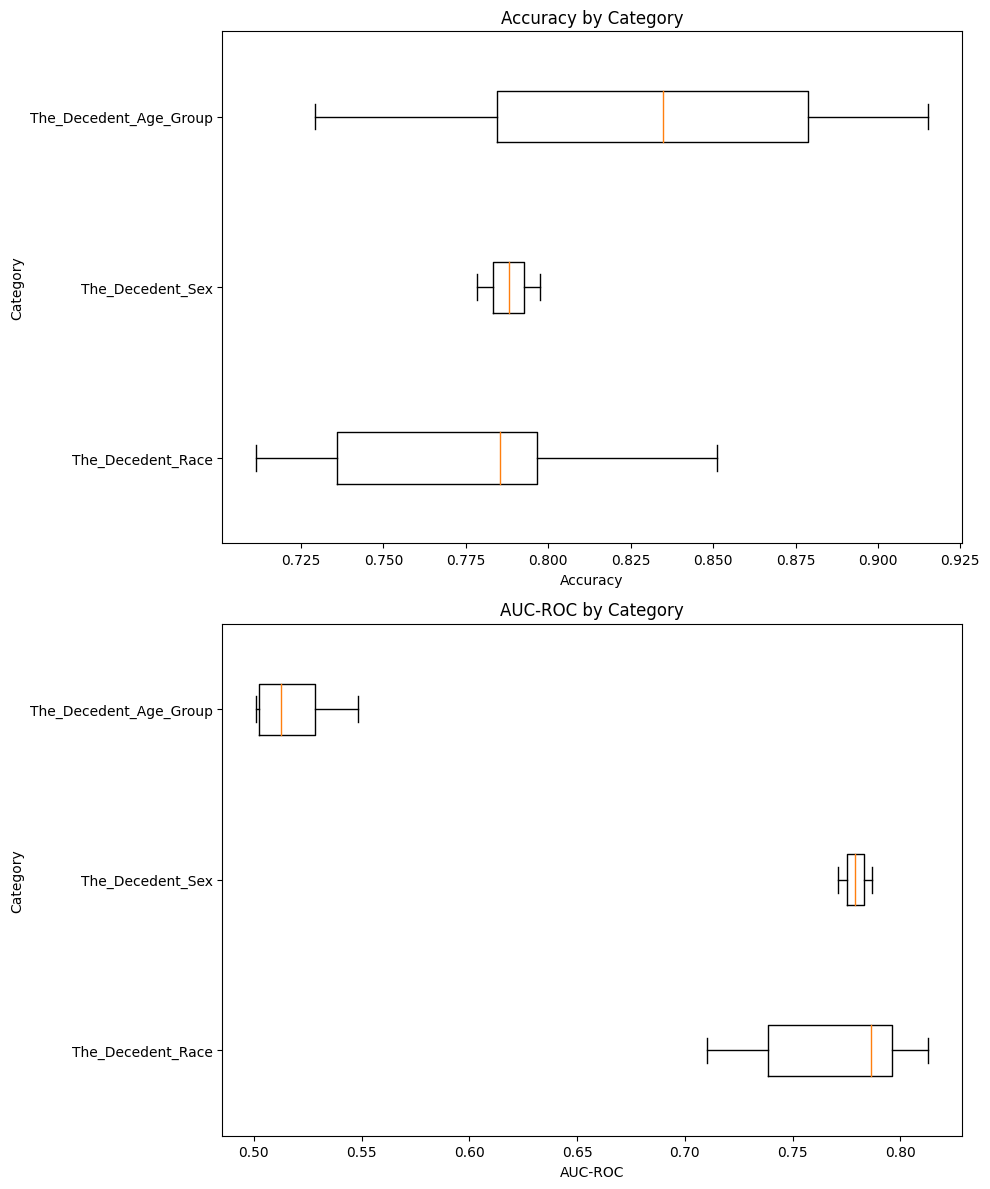

In [24]:
import matplotlib.pyplot as plt

# Define the data
categories = [
    "The_Decedent_Race",
    "The_Decedent_Sex",
    "The_Decedent_Age_Group"
]

values = {
    "The_Decedent_Race": {
        "Accuracy": [(1, 0.7967), (6, 0.7854), (4, 0.8511), (2, 0.7113), (3, 0.7358)],
        "AUC-ROC": [(1, 0.7963), (6, 0.7864), (4, 0.8130), (2, 0.7103), (3, 0.7384)]
    },
    "The_Decedent_Sex": {
        "Accuracy": [("M", 0.7785), ("F", 0.7974)],
        "AUC-ROC": [("M", 0.7870), ("F", 0.7712)]
    },
    "The_Decedent_Age_Group": {
        "Accuracy": [(4, 0.7293), (3, 0.8665), (2, 0.9153), (1, 0.8028)],
        "AUC-ROC": [(4, 0.5219), (3, 0.5031), (2, 0.5010), (1, 0.5482)]
    }
}

# Create a figure and axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Loop through each metric
for i, metric in enumerate(["Accuracy", "AUC-ROC"]):
    ax = axs[i]
    box_data = [list(zip(*values[category][metric]))[1] for category in categories]
    ax.boxplot(box_data, labels=categories, vert=False)
    ax.set_title(f'{metric} by Category')
    ax.set_xlabel(metric)
    ax.set_ylabel('Category')

# Adjust spacing
plt.tight_layout()
plt.show()


# FixEffect for Linear

In [10]:
# Encode labels
train_x['Label'] = train_y
test_x['Label'] = test_y

combined = pd.concat([train_x, test_x], axis=0)

le_dict = {}

for col in combined.columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    le_dict[col] = le

# Split the datasets back, making sure to work with copies
train_x_encoded = combined.iloc[:len(train_x)].copy()
test_x_encoded = combined.iloc[len(train_x):].copy()

# Fix the dtype of 'Label' column
train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

def run_fixed_effect_model_linear(train_x, train_y, test_x, test_y):
    # Work with local copies
    train_x_copy = train_x.copy()
    test_x_copy = test_x.copy()
    
    # Encode labels
    train_x_copy['Label'] = train_y
    test_x_copy['Label'] = test_y

    combined = pd.concat([train_x_copy, test_x_copy], axis=0)

    le_dict = {}
    for col in combined.columns:
        le = LabelEncoder()
        combined[col] = le.fit_transform(combined[col])
        le_dict[col] = le

    train_x_encoded = combined.iloc[:len(train_x_copy)].copy()
    test_x_encoded = combined.iloc[len(train_x_copy):].copy()

    train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

    formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age_Group + The_Decedent_Race + Residence_State'
    
    fixed_effect_model = smf.ols(formula, data=train_x_encoded)
    fixed_effect_model_fit = fixed_effect_model.fit()

    test_df = test_x_encoded.copy()
    test_df['predicted_values'] = fixed_effect_model_fit.predict(test_df)
    test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

    accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
    precision = precision_score(test_df['Label'], test_df['predicted_binary'])
    recall = recall_score(test_df['Label'], test_df['predicted_binary'])
    f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
    roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values'])
    tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()
    
    #print(f'True Positives (TP): {tp}')
    #print(f'False Positives (FP): {fp}')
    #print(f'True Negatives (TN): {tn}')
    #print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    #print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability
    
    return fixed_effect_model

run_fixed_effect_model_linear(train_x, train_y, test_x, test_y)

Accuracy: 0.7839
AUC-ROC: 0.8095
--------------------------------------------------


In [11]:
def evaluate_by_features_linear_model(train_x, train_y, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = run_fixed_effect_model_linear(train_x, train_y, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")


evaluate_by_features_linear_model(train_x, train_y, test_x, test_y)

Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 1
Accuracy: 0.7961
AUC-ROC: 0.8145
--------------------------------------------------
Performance for The_Decedent_Race = 6
Accuracy: 0.7787
AUC-ROC: 0.8175
--------------------------------------------------
Performance for The_Decedent_Race = 4
Accuracy: 0.8520
AUC-ROC: 0.8458
--------------------------------------------------
Performance for The_Decedent_Race = 2
Accuracy: 0.6953
AUC-ROC: 0.7577
--------------------------------------------------
Performance for The_Decedent_Race = 3
Accuracy: 0.7388
AUC-ROC: 0.7507
--------------------------------------------------
Evaluating based on The_Decedent_Sex...
Performance for The_Decedent_Sex = M
Accuracy: 0.7739
AUC-ROC: 0.8068
--------------------------------------------------
Performance for The_Decedent_Sex = F
Accuracy: 0.7973
AUC-ROC: 0.7860
--------------------------------------------------
Evaluating based on The_Decedent_Age_Group...
Performance for The_D

C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7251
AUC-ROC: 0.5694
--------------------------------------------------
Performance for The_Decedent_Age_Group = 3
Accuracy: 0.8663
AUC-ROC: 0.5651
--------------------------------------------------
Performance for The_Decedent_Age_Group = 2
Accuracy: 0.9155
AUC-ROC: 0.5500
--------------------------------------------------
Performance for The_Decedent_Age_Group = 1
Accuracy: 0.7989
AUC-ROC: 0.5144
--------------------------------------------------


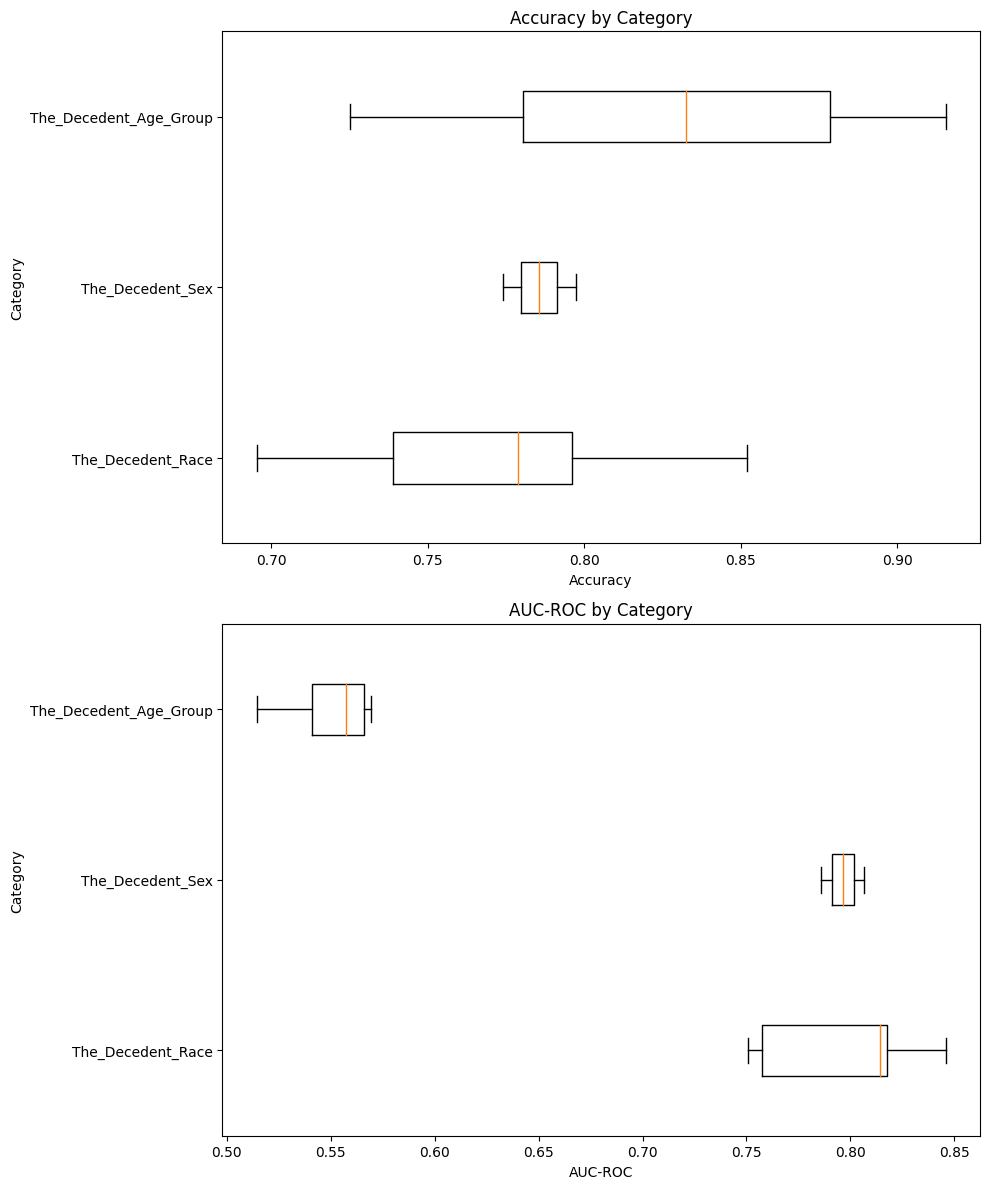

In [23]:
import matplotlib.pyplot as plt

# Define the data
categories = [
    "The_Decedent_Race",
    "The_Decedent_Sex",
    "The_Decedent_Age_Group"
]

values = {
    "The_Decedent_Race": {
        "Accuracy": [(1, 0.7961), (6, 0.7787), (4, 0.8520), (2, 0.6953), (3, 0.7388)],
        "AUC-ROC": [(1, 0.8145), (6, 0.8175), (4, 0.8458), (2, 0.7577), (3, 0.7507)]
    },
    "The_Decedent_Sex": {
        "Accuracy": [("M", 0.7739), ("F", 0.7973)],
        "AUC-ROC": [("M", 0.8068), ("F", 0.7860)]
    },
    "The_Decedent_Age_Group": {
        "Accuracy": [(4, 0.7251), (3, 0.8663), (2, 0.9155), (1, 0.7989)],
        "AUC-ROC": [(4, 0.5694), (3, 0.5651), (2, 0.5500), (1, 0.5144)]
    }
}

# Create a figure and axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Loop through each metric
for i, metric in enumerate(["Accuracy", "AUC-ROC"]):
    ax = axs[i]
    box_data = [list(zip(*values[category][metric]))[1] for category in categories]
    ax.boxplot(box_data, labels=categories, vert=False)
    ax.set_title(f'{metric} by Category')
    ax.set_xlabel(metric)
    ax.set_ylabel('Category')

# Adjust spacing
plt.tight_layout()
plt.show()


# MixEffect

## MixEffect for GPBoost

In [12]:
# 1. Prepare the data

# 2. Define the parameter grid for tuning
param_grid = {
    'max_depth': [7],
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'subsample': [0.9],
    #'gamma': [0.4],
    'reg_alpha': [0.005],
    'reg_lambda': [0.3],
    #'tree_method': ['gpu_hist'],
    #'enable_categorical': [True]
}

# 3. Nested CV for hyperparameter tuning and model evaluation
outer_cv = GroupKFold(n_splits=5)
inner_cv = GroupKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(outer_cv.split(train_x_encoded, groups=train_x_encoded['Residence_State'])):
    
    # Splitting the data
    X_train, X_test = train_x_encoded.iloc[train_idx], train_x_encoded.iloc[test_idx]
    
    # Re-computing the group data for the current fold
    group_data_train = X_train.groupby('Residence_State').size().values
    group_data_test = X_test.groupby('Residence_State').size().values
    
    train_data = gpb.Dataset(data=X_train.drop(columns=['Residence_State', 'Label']), label=X_train['Label'], group=group_data_train)
    test_data = gpb.Dataset(data=X_test.drop(columns=['Residence_State', 'Label']), label=X_test['Label'], group=group_data_test)
    
    # Inner CV for hyperparameter tuning
    model = gpb.GPBoostClassifier()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train.drop(columns=['Residence_State', 'Label']), X_train['Label'], groups=X_train['Residence_State'])

    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Output the best parameters for each fold
    print(f'Best parameters for fold {i + 1}: {best_params}')
    
    # Make predictions and evaluate the performance of the model
    preds_prob = best_model.predict_proba(X_test.drop(columns=['Residence_State', 'Label']))[:, 1]
    
    # Convert predictions to binary outcomes
    threshold = 0.5
    preds_binary = (preds_prob > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(X_test['Label'], preds_binary)
    precision = precision_score(X_test['Label'], preds_binary)
    recall = recall_score(X_test['Label'], preds_binary)
    f1 = f1_score(X_test['Label'], preds_binary)
    roc_auc = roc_auc_score(X_test['Label'], preds_prob)
    tn, fp, fn, tp = confusion_matrix(X_test['Label'], preds_binary).ravel()
    
    # Printing metrics for each fold
    print(f"Fold {i + 1}:")
#     print(f'True Positives (TP): {tp}')
#     print(f'False Positives (FP): {fp}')
#     print(f'True Negatives (TN): {tn}')
#     print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability

Best parameters for fold 1: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 1:
Accuracy: 0.7686
AUC-ROC: 0.8062
--------------------------------------------------
Best parameters for fold 2: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 2:
Accuracy: 0.7838
AUC-ROC: 0.8223
--------------------------------------------------
Best parameters for fold 3: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 3:
Accuracy: 0.7932
AUC-ROC: 0.8128
--------------------------------------------------
Best parameters for fold 4: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 4:
Accuracy: 0.7858
AUC-ROC: 0.8200
--------------------------------------------------
Best parameters for fold 5: {'colsample_

In [13]:
def test_model_mix_effect_gpboost(model, X_test, y_test):
    """
    Test a given model using test data and return evaluation metrics.
    
    Parameters:
    - model : trained model
    - X_test : test feature data
    - y_test : true labels for test data
    
    Returns:
    - metrics : a dictionary containing evaluation metrics
    """
    
    # Make predictions
    preds_prob = model.predict_proba(X_test)[:, 1]
    
    # Convert predictions to binary outcomes
    threshold = 0.5
    preds_binary = (preds_prob > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, preds_binary)
    precision = precision_score(y_test, preds_binary)
    recall = recall_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary)
    roc_auc = roc_auc_score(y_test, preds_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_binary).ravel()
    
    #print(f'True Positives (TP): {tp}')
    #print(f'False Positives (FP): {fp}')
    #print(f'True Negatives (TN): {tn}')
    #print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    #print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability
    
    return None

In [14]:
X_test_data = test_x_encoded.drop(columns=['Residence_State', 'Label'])
y_test_data = test_x_encoded['Label']

test_model_mix_effect_gpboost(best_model, X_test_data, y_test_data)

Accuracy: 0.7850
AUC-ROC: 0.8192
--------------------------------------------------


In [15]:
def evaluate_by_features_mix_effect_gpboost(best_model, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = test_model_mix_effect_gpboost(best_model, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")


evaluate_by_features_mix_effect_gpboost(best_model, X_test_data, y_test_data)

Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 0
Accuracy: 0.7961
AUC-ROC: 0.8169
--------------------------------------------------
Performance for The_Decedent_Race = 4
Accuracy: 0.7787
AUC-ROC: 0.8247
--------------------------------------------------
Performance for The_Decedent_Race = 3
Accuracy: 0.8520
AUC-ROC: 0.8483
--------------------------------------------------
Performance for The_Decedent_Race = 1
Accuracy: 0.7056
AUC-ROC: 0.7646
--------------------------------------------------
Performance for The_Decedent_Race = 2
Accuracy: 0.7388
AUC-ROC: 0.7567
--------------------------------------------------
Evaluating based on The_Decedent_Sex...
Performance for The_Decedent_Sex = 1
Accuracy: 0.7760
AUC-ROC: 0.8209
--------------------------------------------------
Performance for The_Decedent_Sex = 0
Accuracy: 0.7972
AUC-ROC: 0.7939
--------------------------------------------------
Evaluating based on The_Decedent_Age_Group...
Performance for The_D

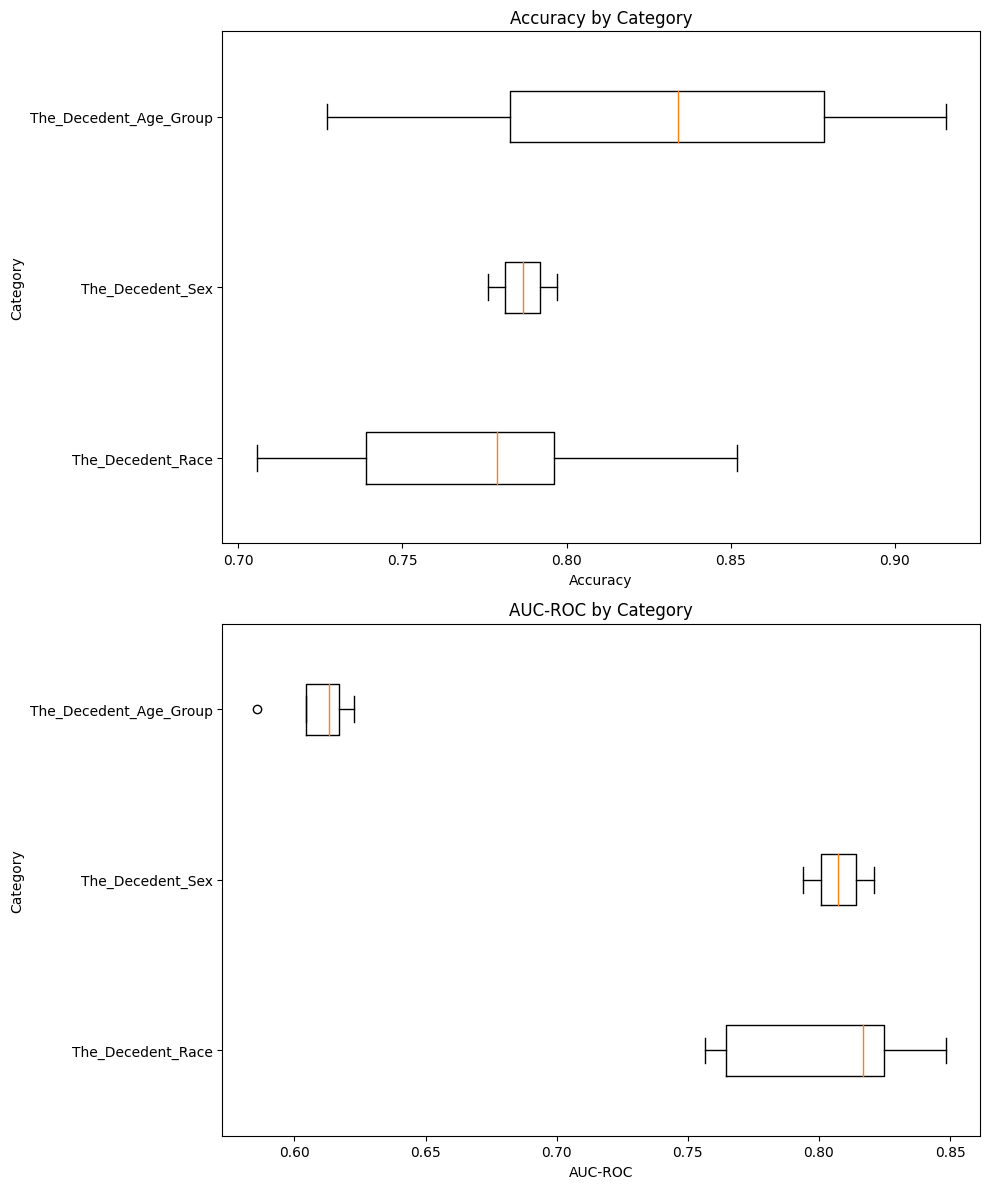

In [21]:
# Define the categories
categories = [
    "The_Decedent_Race",
    "The_Decedent_Sex",
    "The_Decedent_Age_Group"
]

values = {
    "The_Decedent_Race": {
        "Accuracy": [(0, 0.7961), (4, 0.7787), (3, 0.8520), (1, 0.7056), (2, 0.7388)],
        "AUC-ROC": [(0, 0.8169), (4, 0.8247), (3, 0.8483), (1, 0.7646), (2, 0.7567)]
    },
    "The_Decedent_Sex": {
        "Accuracy": [(1, 0.7760), (0, 0.7972)],
        "AUC-ROC": [(1, 0.8209), (0, 0.7939)]
    },
    "The_Decedent_Age_Group": {
        "Accuracy": [(3, 0.7269), (2, 0.8663), (1, 0.9155), (0, 0.8016)],
        "AUC-ROC": [(3, 0.5856), (2, 0.6109), (1, 0.6226), (0, 0.6152)]
    }
}

# Create a figure and axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Loop through each metric
for i, metric in enumerate(["Accuracy", "AUC-ROC"]):
    ax = axs[i]
    box_data = [list(zip(*values[category][metric]))[1] for category in categories]
    ax.boxplot(box_data, labels=categories, vert=False)
    ax.set_title(f'{metric} by Category')
    ax.set_xlabel(metric)
    ax.set_ylabel('Category')

# Adjust spacing
plt.tight_layout()
plt.show()

## MixEffect for Linear 

In [16]:
# Encode labels
train_x['Label'] = train_y
test_x['Label'] = test_y

combined = pd.concat([train_x, test_x], axis=0)

le_dict = {}

for col in combined.columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    le_dict[col] = le

# Split the datasets back, making sure to work with copies
train_x_encoded = combined.iloc[:len(train_x)].copy()
test_x_encoded = combined.iloc[len(train_x):].copy()

# Fix the dtype of 'Label' column
train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

# Define the formula for your mixed effects model
formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age_Group + The_Decedent_Race + (1 | Residence_State)'

# Create a mixed effects model from your data
mixed_effect_model = smf.mixedlm(formula, data=train_x_encoded, groups=train_x_encoded['Residence_State'])

# Fit the model
mixed_effect_model_fit = mixed_effect_model.fit()

# Print the summary
print(mixed_effect_model_fit.summary())

# Predict the outcomes on the test set
test_df = test_x_encoded.copy()
test_df['predicted_values'] = mixed_effect_model_fit.predict(test_df)

# Convert predicted values to binary 0 or 1 based on threshold
test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

# Calculate the metrics
accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
precision = precision_score(test_df['Label'], test_df['predicted_binary'])
recall = recall_score(test_df['Label'], test_df['predicted_binary'])
f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values']) # Use predicted_values for AUC
tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()

# print(f'True Positives (TP): {tp}')
# print(f'False Positives (FP): {fp}')
# print(f'True Negatives (TN): {tn}')
# print(f'False Negatives (FN): {fn}')
print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Label       
No. Observations:    753190     Method:                REML        
No. Groups:          56         Scale:                 0.1747      
Min. group size:     1          Log-Likelihood:        -411976.6882
Max. group size:     68746      Converged:             Yes         
Mean group size:     13449.8                                       
-------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               1.206    0.020   60.655 0.000  1.167  1.245
General_Data_year       0.010    0.000   60.084 0.000  0.010  0.011
The_Decedent_Sex        0.054    0.001   55.195 0.000  0.053  0.056
The_Decedent_Age_Group -0.325    0.001 -531.293 0.000 -0.326 -0.324
The_Decedent_Race      -0.010    0.000  -23.127 0.000 -0.011 -0

In [17]:
def run_mixed_effects_model(model, train_x, train_y, test_x, test_y):
    # Encode labels
    train_x = train_x.copy()
    test_x = test_x.copy()
    train_x['Label'] = train_y
    test_x['Label'] = test_y


    combined = pd.concat([train_x, test_x], axis=0)

    le_dict = {}

    for col in combined.columns:
        combined[col] = combined[col].astype(str)  # Convert all data to string type
        le = LabelEncoder()
        combined[col] = le.fit_transform(combined[col])
        le_dict[col] = le

    train_x_encoded = combined.iloc[:len(train_x)].copy()
    test_x_encoded = combined.iloc[len(train_x):].copy()

    train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

    formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age_Group + The_Decedent_Race + (1 | Residence_State)'

    #mixed_effect_model = smf.mixedlm(formula, data=train_x_encoded, groups=train_x_encoded['Residence_State_And_County'])
    #mixed_effect_model_fit = mixed_effect_model.fit()
    
    mixed_effect_model = model
    
    #print(mixed_effect_model_fit.summary())

    test_df = test_x_encoded.copy()
    test_df['predicted_values'] = mixed_effect_model_fit.predict(test_df)
    test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

    accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
    precision = precision_score(test_df['Label'], test_df['predicted_binary'])
    recall = recall_score(test_df['Label'], test_df['predicted_binary'])
    f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
    roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values'])
    tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()

#     print(f'True Positives (TP): {tp}')
#     print(f'False Positives (FP): {fp}')
#     print(f'True Negatives (TN): {tn}')
#     print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)
    
    return None



temp1 = run_mixed_effects_model(mixed_effect_model, train_x, train_y, test_x, test_y)

Accuracy: 0.7839
AUC-ROC: 0.8089
--------------------------------------------------


In [18]:
def evaluate_by_features_mix_effect_linear(model, train_x, train_y, test_x, test_y):
    features_to_evaluate = [
        'The_Decedent_Race', 
        'The_Decedent_Sex', 
        'The_Decedent_Age_Group', 
    ]

    for feature in features_to_evaluate:
        print(f"Evaluating based on {feature}...")
        
        unique_values = test_x[feature].unique()

        for value in unique_values:
            # Subset data for the specific feature value
            subset_test_x = test_x[test_x[feature] == value]
            subset_test_y = test_y[test_x[feature] == value]
            
            print(f"Performance for {feature} = {value}")
            
            # Evaluate the performance on the subset
            performance = run_mixed_effects_model(model, train_x, train_y, subset_test_x, subset_test_y)

            #print(f"Performance for {feature} = {value}: {performance}")

temp2 = evaluate_by_features_mix_effect_linear(mixed_effect_model, train_x, train_y, test_x, test_y)

Evaluating based on The_Decedent_Race...
Performance for The_Decedent_Race = 1
Accuracy: 0.7961
AUC-ROC: 0.8141
--------------------------------------------------
Performance for The_Decedent_Race = 6
Accuracy: 0.7787
AUC-ROC: 0.8171
--------------------------------------------------
Performance for The_Decedent_Race = 4
Accuracy: 0.8520
AUC-ROC: 0.8448
--------------------------------------------------
Performance for The_Decedent_Race = 2
Accuracy: 0.6953
AUC-ROC: 0.7578
--------------------------------------------------
Performance for The_Decedent_Race = 3
Accuracy: 0.7388
AUC-ROC: 0.7513
--------------------------------------------------
Evaluating based on The_Decedent_Sex...
Performance for The_Decedent_Sex = M
Accuracy: 0.7739
AUC-ROC: 0.8053
--------------------------------------------------
Performance for The_Decedent_Sex = F
Accuracy: 0.7973
AUC-ROC: 0.7860
--------------------------------------------------
Evaluating based on The_Decedent_Age_Group...
Performance for The_D

C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7251
AUC-ROC: 0.5669
--------------------------------------------------
Performance for The_Decedent_Age_Group = 3
Accuracy: 0.8663
AUC-ROC: 0.5685
--------------------------------------------------
Performance for The_Decedent_Age_Group = 2
Accuracy: 0.9155
AUC-ROC: 0.5576
--------------------------------------------------
Performance for The_Decedent_Age_Group = 1
Accuracy: 0.7989
AUC-ROC: 0.5205
--------------------------------------------------


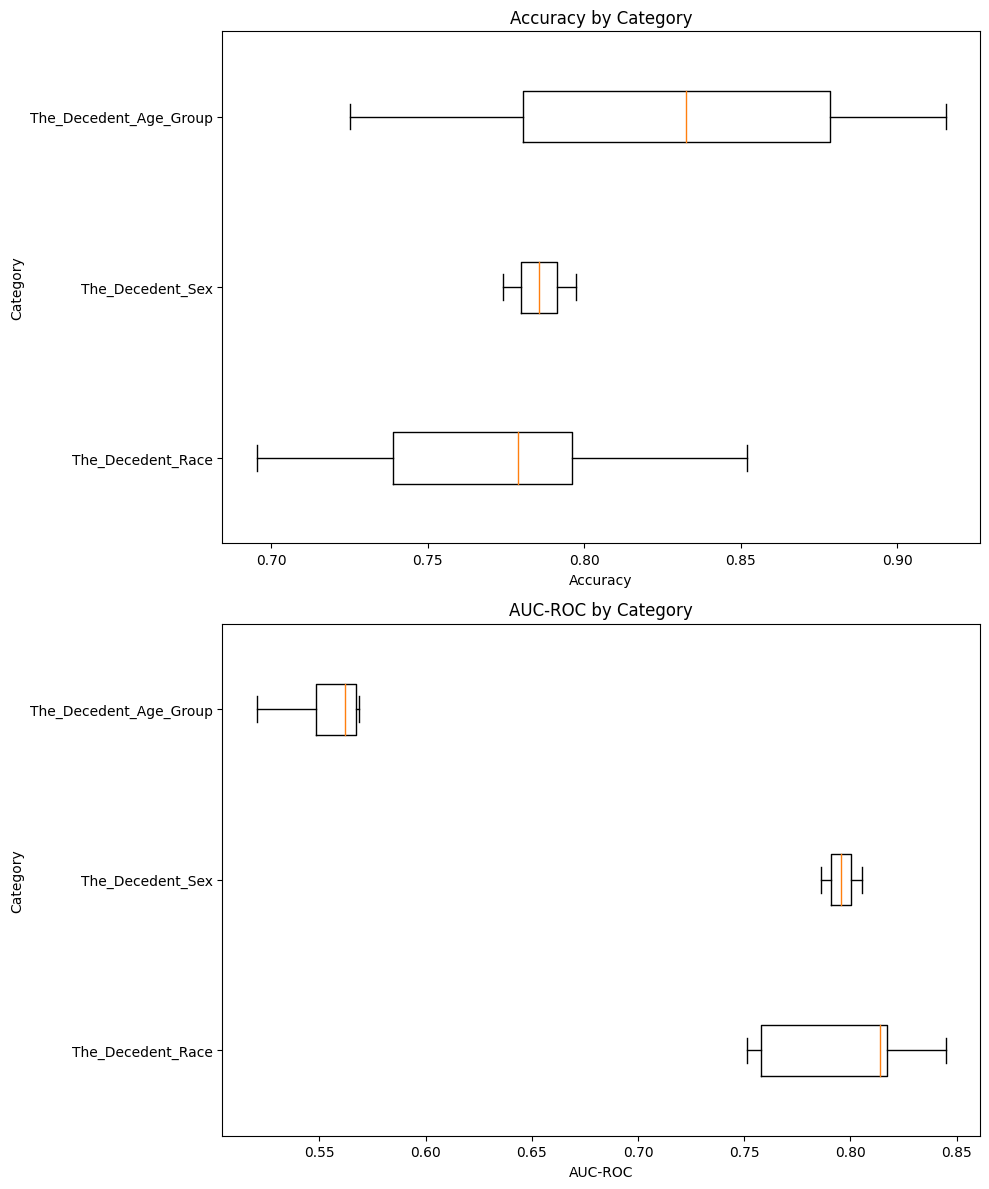

In [22]:
import matplotlib.pyplot as plt

# Define the data
categories = [
    "The_Decedent_Race",
    "The_Decedent_Sex",
    "The_Decedent_Age_Group"
]

values = {
    "The_Decedent_Race": {
        "Accuracy": [(1, 0.7961), (6, 0.7787), (4, 0.8520), (2, 0.6953), (3, 0.7388)],
        "AUC-ROC": [(1, 0.8141), (6, 0.8171), (4, 0.8448), (2, 0.7578), (3, 0.7513)]
    },
    "The_Decedent_Sex": {
        "Accuracy": [("M", 0.7739), ("F", 0.7973)],
        "AUC-ROC": [("M", 0.8053), ("F", 0.7860)]
    },
    "The_Decedent_Age_Group": {
        "Accuracy": [(4, 0.7251), (3, 0.8663), (2, 0.9155), (1, 0.7989)],
        "AUC-ROC": [(4, 0.5669), (3, 0.5685), (2, 0.5576), (1, 0.5205)]
    }
}

# Create a figure and axis
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Loop through each metric
for i, metric in enumerate(["Accuracy", "AUC-ROC"]):
    ax = axs[i]
    box_data = [list(zip(*values[category][metric]))[1] for category in categories]
    ax.boxplot(box_data, labels=categories, vert=False)
    ax.set_title(f'{metric} by Category')
    ax.set_xlabel(metric)
    ax.set_ylabel('Category')

# Adjust spacing
plt.tight_layout()
plt.show()
